In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from astropy.stats import circvar
from astropy import units as u

In [2]:
def replace_area_name(df, area_key):
# df = dataframe containing an area array column
# area_key = string

    df[area_key] = df[area_key].replace(1, 'V1')
    df[area_key] = df[area_key].replace(2, 'LM')
    df[area_key] = df[area_key].replace(3, 'LI')
    
    return df

# HVA well-fit proportion is much lower than V1
why? do we need more cells for LM LI? adjust cell criteria for HVA?

## 1. Are HVA unresponsive to gratings? 
No. avg resp to ad & tg is similar across areas, but tuning curve fluc & pref ori resp is smaller in HVA
- amplitude of resp_ori all around is not lower. Jin2020 Fig 3 ephys also showed this (for AL LM PM)
- cutoff effect of dfof_ad is not big. current cutoff did not affect HVA well-fit cells adp mag much & not more than V1


### Response Amplitude by area

In [5]:
temp = loadmat('C:/Users/lan/Documents/repos/inter/plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit/amp_area.mat')
df = pd.DataFrame(temp['resp_ad'], columns=['resp_ad'])
df['area_ad'] = temp['area_ad']
df['area_ad'] = df['area_ad'].replace(1, 'V1')
df['area_ad'] = df['area_ad'].replace(2, 'LM')
df['area_ad'] = df['area_ad'].replace(3, 'LI')
df.tail()

,resp_ad,area_ad
479,0.010215,LM
480,0.040586,LM
481,0.037092,LM
482,0.035262,LM
483,0.038123,LM


In [6]:
df2 = pd.DataFrame(temp['resp_tg_collapse_ori'], columns=['resp_tg_avg_ori'])
df2['area_tg'] = temp['area_tg']
df2['area_tg'] = df2['area_tg'].replace(1, 'V1')
df2['area_tg'] = df2['area_tg'].replace(2, 'LM')
df2['area_tg'] = df2['area_tg'].replace(3, 'LI')
df2.tail()

,resp_tg_avg_ori,area_tg
407,0.025418,LM
408,0.021595,LM
409,0.058434,LM
410,0.046758,LM
411,0.040096,LM


In [7]:
df.groupby('area_ad', sort=False).describe().reset_index()

area_ad resp_ad                                                              \
            count      mean       std       min       25%       50%       75%   
0      V1   267.0  0.080751  0.069315  0.011885  0.033769  0.057628  0.108478   
1      LM   141.0  0.077834  0.092100  0.010215  0.033665  0.051986  0.092534   
2      LI    76.0  0.068316  0.058048  0.012089  0.029422  0.050297  0.087156   

             
        max  
0  0.486399  
1  0.755541  
2  0.319786

In [8]:
df2.groupby('area_tg', sort=False).describe().reset_index()

area_tg resp_tg_avg_ori                                                    \
                    count      mean       std       min       25%       50%   
0      V1           239.0  0.083117  0.062466  0.009222  0.043842  0.063730   
1      LM           107.0  0.086615  0.092219  0.015696  0.037610  0.057234   
2      LI            66.0  0.078257  0.049079  0.022743  0.042143  0.064019   

                       
        75%       max  
0  0.100160  0.435435  
1  0.103541  0.644160  
2  0.099516  0.241633

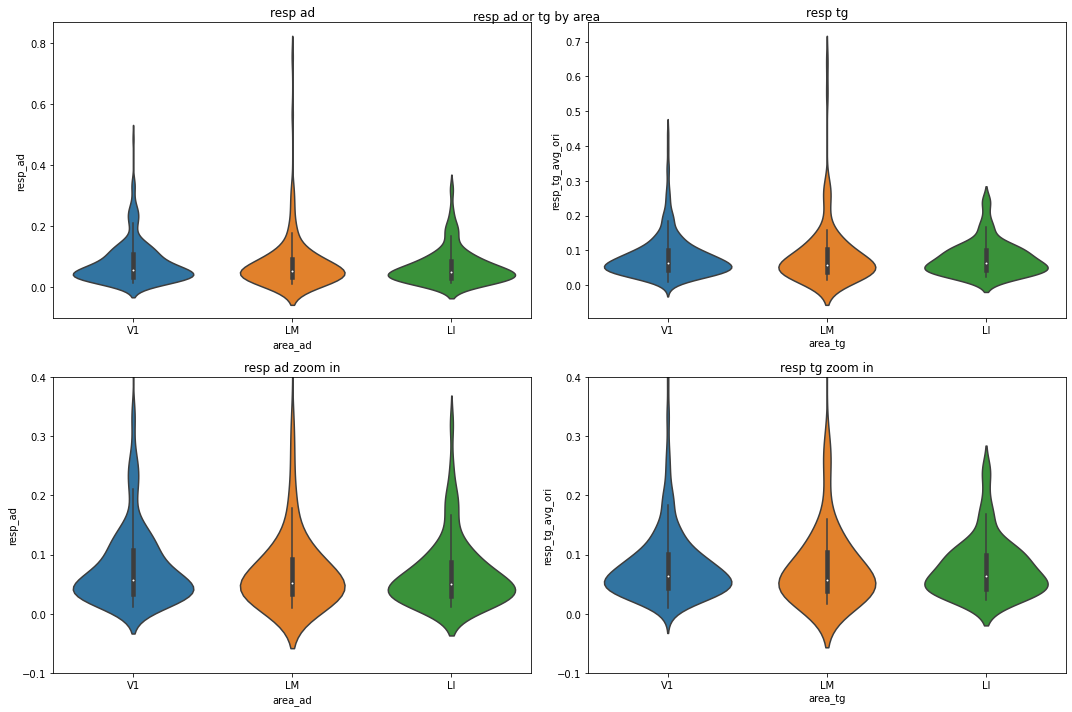

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
fig.suptitle('resp ad or tg by area')

# resp ad
ax = sns.violinplot(ax=axes[0,0], x="area_ad", y="resp_ad", data=df)
axes[0,0].set_title('resp ad')

# resp tg
ax = sns.violinplot(ax=axes[0,1], x="area_tg", y="resp_tg_avg_ori", data=df2)
axes[0,1].set_title('resp tg')

# resp ad zoom in
ax = sns.violinplot(ax=axes[1,0], x="area_ad", y="resp_ad", data=df)
ax.set(ylim=(-0.1, 0.4))
axes[1,0].set_title('resp ad zoom in')

# resp tg zoom in
ax = sns.violinplot(ax=axes[1,1], x="area_tg", y="resp_tg_avg_ori", data=df2)
ax.set(ylim=(-0.1, 0.4))
axes[1,1].set_title('resp tg zoom in')

fig.tight_layout()

### Polar plot of resp_ori by area

In [13]:
ncell_tg = temp['resp_tg'].shape[0]
nori = temp['resp_tg'].shape[1]
resp_tg_cell = []
resp_tg_sorted = np.zeros((ncell_tg, nori))

for icell in np.arange(ncell_tg):
    resp_tg_cell = temp['resp_tg'][icell, :]
    resp_tg_sorted[icell, :] = np.concatenate((resp_tg_cell[np.argmax(resp_tg_cell):len(resp_tg_cell)], resp_tg_cell[0:np.argmax(resp_tg_cell)]))
    
df3 = pd.DataFrame(resp_tg_sorted)
df3['area'] = temp['area_tg']
df3 = replace_area_name(df3, 'area')
df3

,0,1,2,3,4,5,6,7,area
0,0.186297,0.184818,0.095037,0.053145,0.037715,0.041623,0.050704,0.185359,V1
1,0.108755,0.042337,-0.003442,0.007771,-0.021082,-0.017110,0.035048,0.096532,V1
2,0.334310,0.331804,0.054893,0.075347,0.037645,0.046042,0.088307,0.192283,V1
3,0.866983,0.851523,0.237683,0.124013,0.058653,0.050948,0.023531,0.501670,V1
4,0.094991,0.010616,0.023006,0.033687,0.009473,0.022536,0.073898,0.083687,V1
...,...,...,...,...,...,...,...,...,...
407,0.092442,0.050402,0.049153,-0.021308,-0.012517,0.032724,0.009602,0.002845,LM
408,0.059946,-0.015757,0.048349,0.010541,-0.002692,0.018728,0.034506,0.019142,LM
409,0.100901,0.012366,0.078618,0.058513,0.019648,0.067646,0.069631,0.060153,LM
410,0.091941,0.039788,0.039541,0.031566,0.082758,0.014472,0.040642,0.033356,LM


In [14]:
df3.groupby('area', sort=False).count().reset_index()

,area,0,1,2,3,4,5,6,7
0,V1,239,239,239,239,239,239,239,239
1,LM,107,107,107,107,107,107,107,107
2,LI,66,66,66,66,66,66,66,66


In [15]:
df_median = df3.groupby('area', sort=False).median().reset_index()
df_median

,area,0,1,2,3,4,5,6,7
0,V1,0.144829,0.074164,0.049312,0.036211,0.034849,0.035739,0.044892,0.072835
1,LM,0.118889,0.068838,0.051055,0.040134,0.030842,0.039416,0.047986,0.068135
2,LI,0.106541,0.074895,0.054512,0.049813,0.041845,0.056051,0.057500,0.073321


In [16]:
df_mean = df3.groupby('area', sort=False).mean().reset_index()
df_mean

,area,0,1,2,3,4,5,6,7
0,V1,0.189429,0.105789,0.061552,0.050540,0.043605,0.048948,0.060476,0.104599
1,LM,0.159020,0.100637,0.078627,0.058909,0.058579,0.063240,0.077658,0.096254
2,LI,0.135697,0.087246,0.066252,0.053657,0.057660,0.068695,0.070728,0.086117


In [17]:
df3.groupby('area', sort=False).std().reset_index()

,area,0,1,2,3,4,5,6,7
0,V1,0.137807,0.106330,0.062236,0.057600,0.046306,0.062865,0.064945,0.104128
1,LM,0.124312,0.111539,0.096953,0.080087,0.086121,0.084268,0.103900,0.105930
2,LI,0.079208,0.057271,0.051583,0.046024,0.050421,0.054776,0.061219,0.066770


In [18]:
arr_median = df_median.to_numpy()
arr_median = arr_median[0:3, 1:nori+1]

arr_mean = df_mean.to_numpy()
arr_mean = arr_mean[0:3, 1:nori+1]

N = nori * 2
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii_V1_med = np.concatenate((arr_median[0], arr_median[0]))
radii_LM_med = np.concatenate((arr_median[1], arr_median[1]))
radii_LI_med = np.concatenate((arr_median[2], arr_median[2]))
radii_V1_mean = np.concatenate((arr_mean[0], arr_mean[0]))
radii_LM_mean = np.concatenate((arr_mean[1], arr_mean[1]))
radii_LI_mean = np.concatenate((arr_mean[2], arr_mean[2]))
width = np.pi / nori

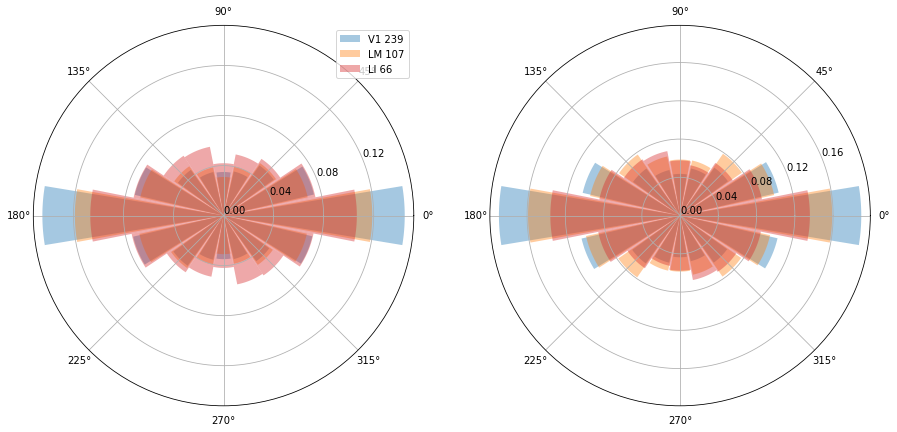

In [19]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(121, projection='polar')
ax.bar(theta, radii_V1_med, width=width/1.2, bottom=0.0, color='C0', alpha=0.4)
ax.bar(theta, radii_LM_med, width=width/1.1, bottom=0.0, color='C1', alpha=0.4)
ax.bar(theta, radii_LI_med, width=width/1.0, bottom=0.0, color='C3', alpha=0.4)
plt.yticks(np.arange(0, 0.16, step=0.04))
ax.legend(['V1 239', 'LM 107', 'LI 66'])

ax = plt.subplot(122, projection='polar')
ax.bar(theta, radii_V1_mean, width=width/1.2, bottom=0.0, color='C0', alpha=0.4)
ax.bar(theta, radii_LM_mean, width=width/1.1, bottom=0.0, color='C1', alpha=0.4)
ax.bar(theta, radii_LI_mean, width=width/1.0, bottom=0.0, color='C3', alpha=0.4)
plt.yticks(np.arange(0, 0.18, step=0.04))
plt.show()

## 2. Are HVA less orientation selective, though responsive to gratings?
No. OSI is more correlated w well-fit & less correlated w area
- OSI & (1 - circular variance) is not lower for well-fit cells, but is lower for all vis driven cells by area]
- well-fit cells have higher OSI
- HVA cells are less well-fit & have lower OSI

### OSI by area
#### for only well-fit cells

In [22]:
OSI_area = loadmat('C:/Users/lan/Documents/repos/inter/plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit/OSI_area.mat')
df = pd.DataFrame(OSI_area['OSI'], columns=['OSI'])
df['area'] = OSI_area['area_merge']
df['area'] = df['area'].replace(1, 'V1')
df['area'] = df['area'].replace(2, 'LM')
df['area'] = df['area'].replace(3, 'LI')
df.tail()

,OSI,area
158,0.715140,V1
159,1.338073,V1
160,0.960019,V1
161,0.439901,V1
162,0.721108,LM


In [23]:
df.groupby('area', sort=False).describe().reset_index()

area    OSI                                                              \
        count      mean       std       min       25%       50%       75%   
0   V1  127.0  0.837365  0.258645  0.223475  0.681109  0.813228  1.007458   
1   LM   26.0  0.779780  0.317639  0.269632  0.553851  0.814957  0.982178   
2   LI   10.0  1.045070  0.452064  0.534157  0.863942  0.940161  1.028255   

             
        max  
0  1.724458  
1  1.697787  
2  2.231971

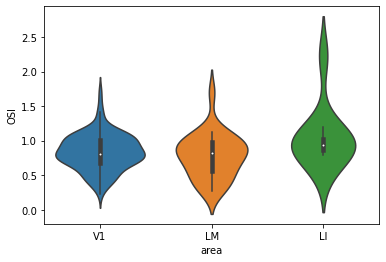

In [24]:
ax = sns.violinplot(x="area", y="OSI", data=df)

#### OSI by area for all vis driven (by tg) cells

In [25]:
OSI_area = loadmat('C:/Users/lan/Documents/repos/inter/plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit/OSI_area_vis.mat')
df = pd.DataFrame(OSI_area['OSI_all'], columns=['OSI'])
df['well_fit'] = OSI_area['well_fit']
df['area'] = OSI_area['area']
df = replace_area_name(df, 'area')
df.tail()

,OSI,well_fit,area
407,1.313234,0,LM
408,1.094038,0,LM
409,0.674029,0,LM
410,0.052561,0,LM
411,0.129447,0,LM


In [27]:
df.groupby('well_fit', sort=False).describe().reset_index()

well_fit    OSI                                                              \
            count      mean       std       min       25%       50%       75%   
0        1  140.0  0.803572  0.253224  0.223475  0.659068  0.797842  0.996368   
1        0  272.0  0.423970  0.361699 -0.504607  0.184252  0.410097  0.618741   

             
        max  
0  1.697787  
1  1.515452

In [28]:
df[['area','well_fit']].groupby('area', sort=False).count().reset_index()

,area,well_fit
0,V1,239
1,LM,107
2,LI,66


In [32]:
df.groupby('area', sort=False).describe().reset_index()

area    OSI                                                              \
        count      mean       std       min       25%       50%       75%   
0   V1  239.0  0.590342  0.374969 -0.504607  0.366039  0.625261  0.861903   
1   LM  107.0  0.525448  0.371482 -0.485548  0.265421  0.496068  0.788313   
2   LI   66.0  0.462201  0.364496 -0.265332  0.226984  0.437112  0.629844   

            well_fit                                               
        max    count      mean       std  min  25%  50%  75%  max  
0  1.515452    239.0  0.451883  0.498724  0.0  0.0  0.0  1.0  1.0  
1  1.697787    107.0  0.242991  0.430908  0.0  0.0  0.0  0.0  1.0  
2  1.302797     66.0  0.090909  0.289683  0.0  0.0  0.0  0.0  1.0

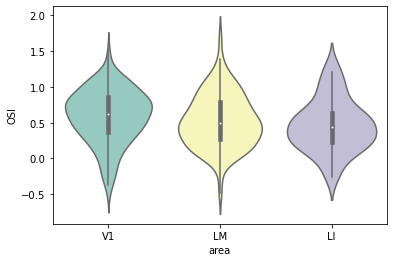

In [31]:
ax = sns.violinplot(x="area", y="OSI", 
                    data=df, palette="Set3", split=False)

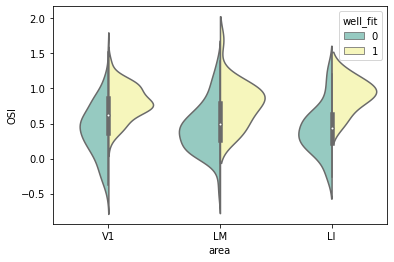

In [29]:
# plt.figure(figsize=(15, 10))
ax = sns.violinplot(x="area", y="OSI", hue="well_fit",
                    data=df, palette="Set3", split=True)

### Circular Variance by area

https://stackoverflow.com/questions/52856232/scipy-circular-variance  
https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Circular_Data_Analysis.pdf  
https://docs.astropy.org/en/stable/api/astropy.stats.circvar.html

In [34]:
temp = loadmat('C:/Users/lan/Documents/repos/inter/plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit/CirVar_area.mat')
ori_list = np.arange(0, 180, 22.5)

ncell = temp['dfof_tg_ori'].shape[0]
nori = 8
cirvar = np.pi * np.ones((ncell, 1))

for icell in range(0, ncell):
    pseudo = [] # pretend there is a dist of angles, to calculate circular variance
    
    for j in range(0, nori):
        pseudo.append([ori_list[j]] * int(temp['dfof_tg_ori'][icell][j])) 
        pseudo_flat = [item for sublist in pseudo for item in sublist]
        cell_data = np.asarray(pseudo_flat)*u.deg
        cirvar[icell] = float(circvar(cell_data))

C:\Users\lan\anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [38]:
df2 = pd.DataFrame(cirvar, columns=['cirvar'])
df2['area'] = temp['area_merge']
df2['area'] = df2['area'].replace(1, 'V1')
df2['area'] = df2['area'].replace(2, 'LM')
df2['area'] = df2['area'].replace(3, 'LI')
df2.tail()

,cirvar,area
158,0.227349,V1
159,0.214398,V1
160,0.217707,V1
161,0.324340,V1
162,0.216299,LM


In [39]:
df2.groupby('area', sort=False).describe().reset_index()

area cirvar                                                              \
        count      mean       std       min       25%       50%       75%   
0   V1  127.0  0.259590  0.158499  0.019122  0.155170  0.220654  0.321424   
1   LM   26.0  0.262714  0.139670  0.082699  0.154470  0.242382  0.317231   
2   LI   10.0  0.172558  0.152244  0.064808  0.090716  0.127283  0.175689   

             
        max  
0  0.740979  
1  0.604651  
2  0.579904

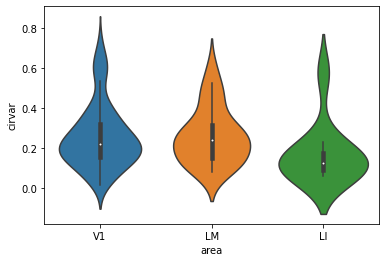

In [41]:
ax = sns.violinplot(x="area", y="cirvar", data=df2)

In [42]:
df3 = pd.DataFrame(df2['area'], columns=['area'])
df3['cir_converge'] = 1 - df2['cirvar']
df3.groupby('area', sort=False).describe().reset_index()

area cir_converge                                                    \
              count      mean       std       min       25%       50%   
0   V1        127.0  0.740410  0.158499  0.259021  0.678576  0.779346   
1   LM         26.0  0.737286  0.139670  0.395349  0.682769  0.757618   
2   LI         10.0  0.827442  0.152244  0.420096  0.824311  0.872717   

                       
        75%       max  
0  0.844830  0.980878  
1  0.845530  0.917301  
2  0.909284  0.935192

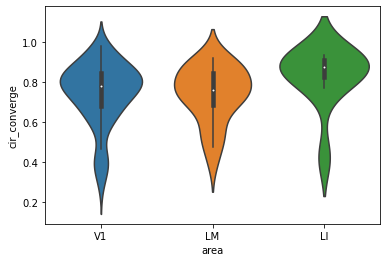

In [43]:
ax = sns.violinplot(x="area", y="cir_converge", data=df3)

### Do HVAs have "bad" tuning curve shape that does not match von mises function? 
stability & R2 of fit is lower?
- closeness of fit: R2 is slightly higher in V1 than HVAs

### R2 & SSE (sum of squared estimate of errors) by area

In [46]:
temp = loadmat('C:/Users/lan/Documents/repos/inter/plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit/R2_SSE_area.mat')
df = pd.DataFrame(temp['area'], columns=['area'])
df['R2'] = temp['R2']
df['SSE'] = temp['SSE']
replace_area_name(df, 'area')

,area,R2,SSE
0,V1,0.909820,0.003040
1,V1,0.982684,0.001656
2,V1,0.936868,0.006974
3,V1,0.954914,0.039923
4,V1,0.786928,0.001786
...,...,...,...
158,V1,0.942606,0.000784
159,V1,0.885957,0.000836
160,V1,0.734667,0.003140
161,V1,0.897751,0.003376


In [47]:
df[['area','R2']].groupby('area', sort=False).describe().reset_index()

area     R2                                                              \
        count      mean       std       min       25%       50%       75%   
0   V1  127.0  0.898126  0.081856  0.607792  0.849890  0.916412  0.961780   
1   LM   26.0  0.913381  0.064245  0.692570  0.881454  0.924761  0.954968   
2   LI   10.0  0.916711  0.056700  0.805935  0.909021  0.928038  0.952924   

             
        max  
0  0.997551  
1  0.994080  
2  0.976053

In [48]:
df[['area','SSE']].groupby('area', sort=False).describe().reset_index()

area    SSE                                                              \
        count      mean       std       min       25%       50%       75%   
0   V1  127.0  0.004237  0.006489  0.000059  0.001155  0.002518  0.004275   
1   LM   26.0  0.003188  0.004202  0.000206  0.000862  0.001422  0.004325   
2   LI   10.0  0.002108  0.001678  0.000124  0.000637  0.001921  0.003553   

             
        max  
0  0.042927  
1  0.020104  
2  0.004730

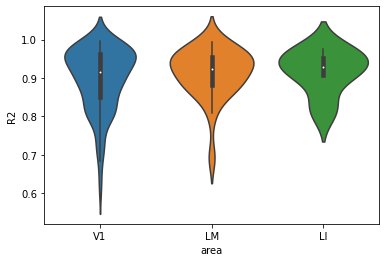

In [49]:
ax = sns.violinplot(x="area", y="R2", data=df)

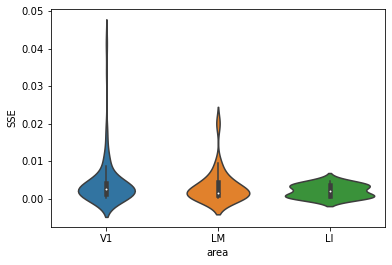

In [50]:
ax = sns.violinplot(x="area", y="SSE", data=df)

In [52]:
temp = loadmat('C:/Users/lan/Documents/repos/inter/plot/CV SNR OSI R2 ori_perc by area - why HVA lack well fit/R2_SSE_all_area.mat')
df = pd.DataFrame(temp['area'], columns=['area'])
df['R2'] = temp['R2']
df['SSE'] = temp['SSE']
replace_area_name(df, 'area')

,area,R2,SSE
0,V1,0.909820,0.003040
1,V1,0.912416,0.001510
2,V1,0.982684,0.001656
3,V1,0.936868,0.006974
4,V1,0.954914,0.039923
...,...,...,...
534,LM,0.475880,0.002292
535,LM,0.399251,0.001712
536,LM,0.096769,0.015097
537,LM,0.262120,0.004684


In [53]:
df[['area','R2']].groupby('area', sort=False).describe().reset_index()

area     R2                                                                  \
        count      mean       std           min       25%       50%       75%   
0   V1  293.0  0.697709  0.281087 -6.950965e-01  0.554520  0.795207  0.915681   
1   LM  160.0  0.608380  0.263517 -3.298091e-01  0.403744  0.665774  0.835812   
2   LI   86.0  0.588485  0.253185 -6.166112e-11  0.438111  0.594939  0.794711   

             
        max  
0  0.997551  
1  0.994080  
2  0.976053

In [54]:
df[['area','SSE']].groupby('area', sort=False).describe().reset_index()

area    SSE                                                              \
        count      mean       std       min       25%       50%       75%   
0   V1  293.0  0.004984  0.010519  0.000059  0.001273  0.002644  0.004777   
1   LM  160.0  0.003071  0.003400  0.000146  0.001020  0.001981  0.003832   
2   LI   86.0  0.003095  0.002588  0.000124  0.001113  0.002728  0.004359   

             
        max  
0  0.142692  
1  0.020755  
2  0.015255

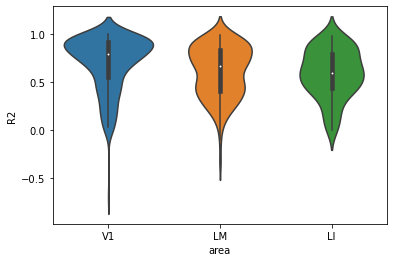

In [55]:
ax = sns.violinplot(x="area", y="R2", data=df)

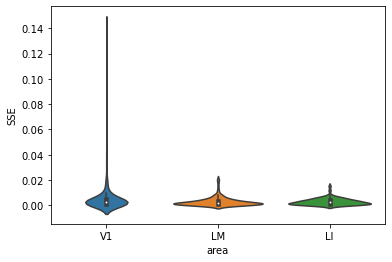

In [56]:
ax = sns.violinplot(x="area", y="SSE", data=df)